In [1]:
using Pkg
Pkg.activate(".")
#for pkg in ["BlackBoxOptim", "Cubature", "Distributions", "Integrals", "Roots", "PythonPlot", "Zygote", "PrettyTables", "StatProfilerHTML"] # 
#    Pkg.add(pkg)
#end
# ] conda add matplotlib
#Pkg.instantiate()

using BlackBoxOptim, Cubature, Distributions, Integrals, Random, Roots, PythonPlot, PrettyTables

  Activating project at `C:\Users\jbrig\Documents\research\mapinator_2024`
    CondaPkg Found dependencies: C:\Users\jbrig\Documents\research\mapinator_2024\CondaPkg.toml
    CondaPkg Found dependencies: C:\Users\jbrig\.julia\packages\PythonCall\Nr75f\CondaPkg.toml
    CondaPkg Found dependencies: C:\Users\jbrig\.julia\packages\PythonPlot\469aA\CondaPkg.toml
    CondaPkg Dependencies already up to date


In [2]:
unmatched = [367 599 752 413 341] 

res = (; placements = [1194 338 172 43 4; 
950 853 314 91 10; 
1073 1381 986 146 34; 
270 506 451 409 33; 
0 42 53 28 163; 
568 545 285 57 23; 
777 441 230 55 26; 
86 130 135 56 27;
34 59 69 41 48; 
210 165 83 32 9;
240 377 420 159 69]) 

k = 5
K = k + 6
M = sum(res.placements)

successful_graduates = [sum(res.placements[:, t]) for t in 1:k]
println("successful graduates: ", M)
println(successful_graduates)
println("unmatched graduates:  ", sum(unmatched))
println(unmatched)
println()

m_t = [(sum(res.placements[:, t]) + unmatched[t]) for t in 1:k]
m_val = sum(m_t)
println("total graduates: ", m_val)
println(m_t)

failure_prob = [unmatched[t] / (sum(res.placements[:, t]) + unmatched[t]) for t in 1:k]
success_prob = [1 - failure_prob[t] for t in 1:k]
println("probabilities of success within each tier: ", success_prob)
println("probabilities of failure within each tier: ", failure_prob)

successful graduates: 15000
[5402, 4837, 3198, 1117, 446]
unmatched graduates:  2472
[367 599 752 413 341]

total graduates: 17472
[5769, 5436, 3950, 1530, 787]
probabilities of success within each tier: [0.936384122031548, 0.8898086828550404, 0.809620253164557, 0.7300653594771243, 0.5667090216010164]
probabilities of failure within each tier: [0.06361587796845207, 0.11019131714495953, 0.19037974683544304, 0.2699346405228758, 0.4332909783989835]


In [3]:
# define p_vec as e.g.
# [v2/v1 v3/v2 v4/v3 α1 α2 α3 α4 mu1 mu2 mu3 mu4 mus sg1 sg2 sg3 sg4 sgs]

function q_prob(t, v_rel, mkt_balance_ratio, gamma, k)
    numerator = prod([v_rel[s] for s in t:k-1])
    denominator = exp(1 / mkt_balance_ratio) * prod([((v_rel[s])^(sum(gamma[1:s]))) for s in 1:k-1])
    return numerator / denominator
end

function F(x, ρ, normals, K)
    sum_base = 0.0
    for i in 1:K
        sum_base += ρ[i] * cdf(normals[i], x)
    end
    return sum_base
end

function f_integrand(integrals, x, p) 
    base_exp = exp(F(x, p.ρ, p.normals, p.K) / sum(p.α[1:p.s]))
    for i in 1:p.K
        integrals[i] = base_exp * pdf(p.normals[i], x)
    end
end

function get_integrals(x_vec, ρ, normals, α, k, K)
    # Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    # x_vec[s] = x_{s-1}, so the limits of integration are and must be offset by 1 below
    all_integrals = zeros(K, k)
    for s in 1:k
        prob = IntegralProblem(IntegralFunction(f_integrand, zeros(K)), (x_vec[s+1], x_vec[s]), (; s, ρ, normals, α, K))
        sol = solve(prob, CubatureJLh(); reltol = 1e-3, abstol = 1e-3)
        integrals_result = sol.u
        # NOTE: result may be inf if alpha_1 is too small
        # NOTE: some parameter values for μ and σ may cause the cdf F_i to be NaN
        for i in 1:K 
            all_integrals[i, s] = integrals_result[i]
        end
    end
    return all_integrals
end      

function q(i, t, all_integrals, Fx_vec, α, v_rel, k)
    return α[t] * sum([(1/sum(α[1:s])) * prod([v_rel[j] for j in t:(s-1)]) * exp(-Fx_vec[s] / sum(α[1:s])) * all_integrals[i, s] for s in t:k])
end

function Fx(t, α, v_rel)
    return 1 - sum([-log(v_rel[j])*sum(α[1:j]) for j in 1:t])
end

function pi(t, α)
    return α[t] / sum(α[1:t])
end

pi (generic function with 1 method)

In [4]:
function estimate_likelihood_2(p_vec, placements, Fail, k, K, penalty_constant)
    v_rel = p_vec[1:k-1]
    gamma_vec = p_vec[k:2k-1]
    gamma = gamma_vec / sum(gamma_vec)
    mkt_balance_ratio = p_vec[2k]
    q_vec = [q_prob(t, v_rel, mkt_balance_ratio, gamma, k) for t in 1:k]
    for t in 1:k
        if q_vec[t] > 1 || q_vec[t] < 0
            return Inf
        end
    end

    n_val = ((sum(placements) + sum(Fail)) / mkt_balance_ratio) + 1
    α = mkt_balance_ratio * gamma
    μ = p_vec[2k+1:2k+K]
    σ = p_vec[2k+K+1:2k+2K]
    ρ_vec = p_vec[2k+2K+1:2k+3K]
    ρ = ρ_vec / sum(ρ_vec)

    graduate_success_prob = 1 - sum([gamma[t] * q_vec[t] for t in 1:k])

    ## compute the cutoffs x and the CDF values F(x)
    normals = [truncated(Normal(μ[i], σ[i]), 0, 1) for i in 1:K]

    Fx_vec = ones(k) # sets F(x0) = 1 by default; Fx_vec = [F(x0)=1, F(x1), F(x2), F(x3), ..., F(xk-1)]
    x_vec = ones(k+1) # x_vec = [x0 = 1, x1, x2, x3, ..., xk = 0]
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0 # TODO: if this case occurs, can we speed up q()?
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        # there is no simple closed-form for F^{-1}(x) so this numerically computes x1, x2, x3
        x_vec[t+1] = find_zero(x -> F(x, ρ, normals, K) - Fx_vec[t+1], 0.5) 
    end 

    q_it = zeros(K, k)
    ρ_q_it = zeros(K, k)
    all_integrals = get_integrals(x_vec, ρ, normals, α, k, K)
    for i in 1:K, t in 1:k
        prob = q(i, t, all_integrals, Fx_vec, α, v_rel, k)
        q_it[i, t] = prob
        ρ_q_it[i, t] = ρ[i] * prob
    end

    normalizer = sum(ρ_q_it)
    likelihood = 0.0
    for i in 1:K, t in 1:k
        likelihood += placements[i, t] * log(graduate_success_prob * (ρ_q_it[i, t] / normalizer))
    end
    likelihood += sum([Fail[t] * log(gamma[t] * q_vec[t]) for t in 1:k]) 

    # https://github.com/robertfeldt/BlackBoxOptim.jl/blob/master/examples/constrained_problem_with_equality_and_inequalities.jl
    # https://github.com/robertfeldt/BlackBoxOptim.jl/blob/master/examples/constrained_problem_with_inequalities.jl
    
    subpenalties = zeros(K)
    total_sum = sum(placements) + sum([n_val * ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    for i in 1:K
        predicted_ρ_i_output = (sum(placements[i, :]) + n_val * ρ[i] * (1 - sum([q_it[i, t] for t in 1:k]))) / total_sum
        subpenalties[i] = abs(predicted_ρ_i_output - ρ[i])
    end
    residual = sqrt(sum(subpenalties .^ 2))
    #print("$(-likelihood) ")
    return (-likelihood) + (penalty_constant * residual)
end

estimate_likelihood_2 (generic function with 1 method)

In [5]:
Random.seed!(0)

# upper/lower bound on v_rel
upper_2 = [1.0 for _ in 1:k-1]
lower_2 = [0.0 for _ in 1:k-1]

# upper/lower bound on gamma-proportionate variables
append!(upper_2, [1.0 for _ in 1:k])
append!(lower_2, [0.0 for _ in 1:k])

# upper/lower bound on mkt balance ratio
append!(upper_2, [1.0 for _ in 1:1])
append!(lower_2, [0.35 for _ in 1:1])

# upper/lower bound on the mu parameter of truncated normal
append!(upper_2, [4.0 for _ in 1:K])
append!(lower_2, [-4.0 for _ in 1:K])

# upper/lower bound on the sigma parameter of truncated normal
append!(upper_2, [10.0 for _ in 1:K])
append!(lower_2, [0.001 for _ in 1:K])

# upper/lower bound on values proportional to ρ_i
append!(upper_2, [1.0 for _ in 1:K])
append!(lower_2, [0.0 for _ in 1:K])

penalty_constant = 1e3

search_range_2 = [(lower_2[i], upper_2[i]) for i in eachindex(upper_2)]
sol_res_2 = bboptimize(p -> estimate_likelihood_2(p, res.placements, unmatched, k, K, penalty_constant), SearchRange = search_range_2, MaxTime = 600.0, TraceInterval = 5) 
# MaxTime = 60.0, MaxFuncEvals = 1000000,
sol_2 = best_candidate(sol_res_2)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
5.00 secs, 26592 evals, 25294 steps, improv/step: 0.250 (last = 0.2499), fitness=62450.375573014
10.00 secs, 35693 evals, 34339 steps, improv/step: 0.227 (last = 0.1617), fitness=62198.143663402
15.00 secs, 39507 evals, 38150 steps, improv/step: 0.220 (last = 0.1580), fitness=62173.238129450
20.01 secs, 42059 evals, 40703 steps, improv/step: 0.215 (last = 0.1355), fitness=62165.649517595
25.01 secs, 44692 evals, 43330 steps, improv/step: 0.209 (last = 0.1252), fitness=62160.503352967
30.02 secs, 46965 evals, 45603 steps, improv/step: 0.205 (last = 0.1302), fitness=62153.036281849
35.02 secs, 48997 evals, 47635 steps, improv/step: 0.200 (last = 0.0906), fitness=62150.140893191
40.02 secs, 51089 evals, 49727 steps, improv/step: 0.196 (last = 0.1099), fitness=62147.211536733
45.02 secs, 5

43-element Vector{Float64}:
  0.5535828768428621
  0.6240199564770049
  0.5927391041394452
  0.497076550206684
  0.9396741007999003
  0.8849047334184708
  0.642630030284392
  0.24870221906604328
  0.12780149461165433
  0.46037539892875634
 -3.9934761363864286
  0.3059167674281719
  0.24056855926340437
  ⋮
  0.7008105571921219
  0.3581779835677681
  0.5350624993245183
  0.9956244296127411
  0.7612930250776493
  0.21121848296692547
  0.3916953938188512
  0.38297322325918765
  0.18605093565399808
  0.19672831249243392
  0.1393824315403026
  0.5389743371305954

In [6]:
estimated_v_rel = sol_2[1:k-1]
println("estimated value ratios:")
display(estimated_v_rel)
println()
estimated_v_base = 1
for i in 1:k
    println("v", i, ": ", estimated_v_base)
    if i != k
        estimated_v_base = estimated_v_rel[i] * estimated_v_base
    end
end
println()

estimated_gamma_vec = sol_2[k:2k-1]
estimated_gamma = estimated_gamma_vec / sum(estimated_gamma_vec)
println("estimated m_t / m: ", estimated_gamma)
println()

estimated_market_balance_ratio = sol_2[2k]
println("estimated market balance ratio (m / (n-1)): ", estimated_market_balance_ratio)

estimated_n_val = (m_val / estimated_market_balance_ratio) + 1
println("estimated total departments: ", estimated_n_val)
estimated_α = estimated_market_balance_ratio * estimated_gamma
println("estimated α_t: ", estimated_α)

estimated value ratios:


4-element Vector{Float64}:
 0.5535828768428621
 0.6240199564770049
 0.5927391041394452
 0.497076550206684


v1: 1
v2: 0.5535828768428621
v3: 0.345446762713898
v4: 0.20475980465890742
v5: 0.1017812973208442

estimated m_t / m: [0.3304391969884479, 0.3111793857819041, 0.22598276464901268, 0.08745687625898343, 0.04494177632165191]

estimated market balance ratio (m / (n-1)): 0.46037539892875634
estimated total departments: 37952.63694814156
estimated α_t: [0.1521260771352546, 0.14325933386774947, 0.10403690542631247, 0.04026299429679238, 0.020690088202647432]


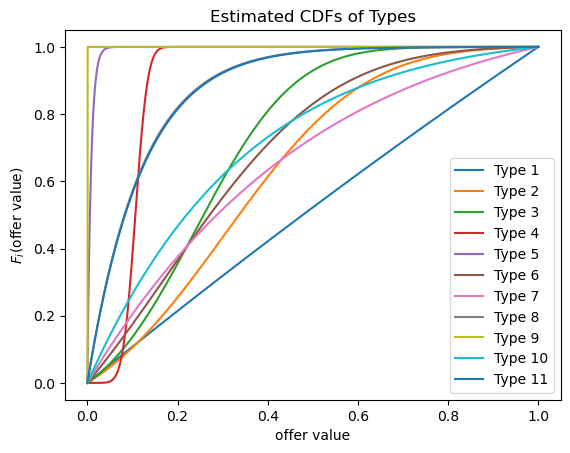

In [7]:
point_grid = [i for i in range(0, 1; length = 10001)]
for select_type in 1:K
    plot(point_grid, [cdf(truncated(Normal(sol_2[2k+select_type], sol_2[2k+select_type+K]), 0, 1), x) for x in point_grid], label = string("Type ", select_type))
end

title("Estimated CDFs of Types")
xlabel("offer value")
ylabel("\$F_i\$(offer value\$)\$")
legend();

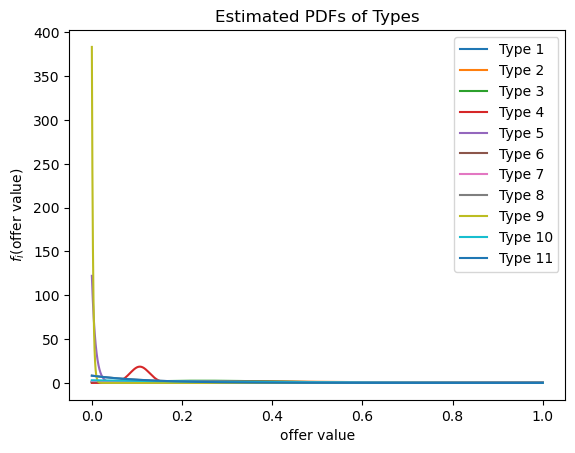

In [8]:
for select_type in 1:K
    plot(point_grid, [pdf(truncated(Normal(sol_2[2k+select_type], sol_2[2k+select_type+K]), 0, 1), x) for x in point_grid], label = string("Type ", select_type))
end
title("Estimated PDFs of Types")
xlabel("offer value")
ylabel("\$f_i\$(offer value\$)\$")
legend();

In [9]:
for select_type in 1:K
    println("Type $(select_type):")
    println("  est. mean:   ", mean(truncated(Normal(sol_2[2k+select_type], sol_2[2k+select_type+K]), 0, 1)))
    println("  est. stddev: ", std(truncated(Normal(sol_2[2k+select_type], sol_2[2k+select_type+K]), 0, 1)))
    println()
end

Type 1:
  est. mean:   0.4850941009266059
  est. stddev: 0.28825244655448096

Type 2:
  est. mean:   0.35215131093740515
  est. stddev: 0.20021525162565418

Type 3:
  est. mean:   0.2682146352291683
  est. stddev: 0.1479321118263307

Type 4:
  est. mean:   0.10639058928336304
  est. stddev: 0.021473419408208037

Type 5:
  est. mean:   0.008015150775077362
  est. stddev: 0.007858012237412912

Type 6:
  est. mean:   0.3005325215575198
  est. stddev: 0.20050783138912667

Type 7:
  est. mean:   0.3452710787984725
  est. stddev: 0.26125982386634017

Type 8:
  est. mean:   0.11656661378231892
  est. stddev: 0.11339470746179971

Type 9:
  est. mean:   0.0025730458327907213
  est. stddev: 0.0025394629355047003

Type 10:
  est. mean:   0.28354109802828464
  est. stddev: 0.23512805964665523

Type 11:
  est. mean:   0.11823463882108598
  est. stddev: 0.1149027556005038



In [17]:
function print_metrics(p_vec, placements, Fail, k, K, M, m_val, penalty_constant)
    v_rel = p_vec[1:k-1]
    gamma_vec = p_vec[k:2k-1]
    gamma = gamma_vec / sum(gamma_vec)
    mkt_balance_ratio = p_vec[2k]
    q_vec = [q_prob(t, v_rel, mkt_balance_ratio, gamma, k) for t in 1:k]

    α = mkt_balance_ratio * gamma
    n_val = (m_val / mkt_balance_ratio) + 1
    
    μ = p_vec[2k+1:2k+K]
    σ = p_vec[2k+K+1:2k+2K]
    ρ_vec = p_vec[2k+2K+1:2k+3K]
    ρ = ρ_vec / sum(ρ_vec)
    normals = [truncated(Normal(μ[i], σ[i]), 0, 1) for i in 1:K]
    
    n = n_val * ρ
    graduate_success_prob = 1 - sum([gamma[t] * q_vec[t] for t in 1:k])

    ρ_q_it_true = placements / n_val
    
    Fx_vec = ones(k)
    x_vec = ones(k+1)
    x_vec[k+1] = 0.0
    for t in 1:k-1
        Fx_vec_candidate = Fx(t, α, v_rel)
        if Fx_vec_candidate <= 0.0
            Fx_vec[t+1:k] .= 0.0
            x_vec[t+1:k] .= 0.0
            break
        end
        Fx_vec[t+1] = Fx_vec_candidate
        x_vec[t+1] = find_zero(x -> F(x, ρ, normals, K) - Fx_vec[t+1], 0.5) 
    end

    objective_chisquare = 0.0
    objective_likelihood = 0.0
    normalizer = 0.0
    
    q_it = zeros(K, k)
    ρ_i_q_it = zeros(K, k)
    all_integrals = get_integrals(x_vec, ρ, normals, α, k, K)
    for i in 1:K, t in 1:k
        prob = q(i, t, all_integrals, Fx_vec, α, v_rel, k)
        q_it[i, t] = prob
        ρ_i_q_it[i, t] = ρ[i] * prob
        normalizer += ρ[i] * prob
    end

    round_1_failure = zeros(K)
    for i in 1:K
        round_1_failure[i] = (1 - sum([q_it[i, s] for s in 1:k]))
    end
    
    # TODO: div by zero and negative floating point in mean
    exp_placements = zeros(K, k)
    exp_fail = zeros(k)
    for i in 1:K, t in 1:k 
        expectation = n[i] * q_it[i, t]
        exp_placements[i, t] = expectation
        prob = ρ_i_q_it[i, t]
        objective_chisquare += (placements[i, t] - expectation) ^ 2 / expectation
        objective_likelihood += placements[i, t] * log(graduate_success_prob * (ρ[i] * q_it[i, t] / normalizer))
    end
    objective_chisquare_full = objective_chisquare
    for t in 1:k
        exp_fail[t] = m_val * gamma[t] * q_vec[t]
        objective_chisquare_full += (Fail[t] - exp_fail[t]) ^ 2 / exp_fail[t]
    end
    objective_likelihood += sum([Fail[t] * log(gamma[t] * q_vec[t]) for t in 1:k]) 
    
    # https://github.com/robertfeldt/BlackBoxOptim.jl/blob/master/examples/constrained_problem_with_equality_and_inequalities.jl
    # https://github.com/robertfeldt/BlackBoxOptim.jl/blob/master/examples/constrained_problem_with_inequalities.jl
    
    subpenalties = zeros(K)
    total_sum = sum(placements) + sum([n_val * ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    for i in 1:K
        predicted_ρ_i_output = (sum(placements[i, :]) + n_val * ρ[i] * (1 - sum([q_it[i, t] for t in 1:k]))) / total_sum
        subpenalties[i] = abs(predicted_ρ_i_output - ρ[i])
    end
    residual = sqrt(sum(subpenalties .^ 2))

    println("chi-square objective value (successful placements) = ", objective_chisquare)
    println("chi-square objective value (all graduates) = ", objective_chisquare_full)
    # TODO: evaluate actual likelihood
    println("value proportional to likelihood = ", -objective_likelihood)
    println("value proportional to constrained likelihood = ", (-objective_likelihood) + (penalty_constant * residual))
    println("constraint residual: ", residual)
    println("penalty constant * residual: ", penalty_constant * residual)
    println("constraint errors:")
    display(subpenalties)
    println()
    println()
    println("estimated total departments = ", n_val)
    println("successful departments in sample = ", M)
    println("estimated unsuccessful departments = ", n_val - M)
    println("estimated probability of department success: ", M / n_val)
    println("predicted probability of department success: ", normalizer)
    println("estimated probability of department failure: ", 1 - (M / n_val))
    println()
    println("estimated beliefs of proportion of departments in each tier:")
    for i in 1:K
        println("ρ_", i, " = ", ρ[i])
    end
    println()
    println("estimated departments in each tier:")
    for i in 1:K
        println("n_", i, " = ", n[i])
        println("  Successful: ", sum(placements[i, :]))
        println("  Unsuccessful: ", n[i] - sum(placements[i, :]))
        println("  Estimated success probability: ", sum(placements[i, :]) / n[i])
        println("  Estimated failure probability: ", 1 - (sum(placements[i, :]) / n[i]))
    end
    println()

    println("rational expectations condition:")
    total_sum = sum(placements) + sum([n_val * ρ[i] * (1 - sum([q_it[i, t] for t in 1:k])) for i in 1:K])
    for i in 1:K
        predicted_ρ_output = (sum(placements[i, :]) + n_val * ρ[i] * (1 - sum([q_it[i, t] for t in 1:k]))) / total_sum
        println("tier ", i)
        println("  Input rho: ", ρ[i])
        println("  Predicted rho: ", predicted_ρ_output)
        println("  Predicted - Input: ", predicted_ρ_output - ρ[i])
        println("  Squared Difference: ", (predicted_ρ_output - ρ[i])^2)
    end
    println()

    println("expected number of tier i departments making offers to tier t graduates:")
    tier_selection_matrix = zeros(K, k)
    for i in 1:K, t in 1:k 
        tier_selection_matrix[i, t] = n_val * ρ[i] * sum([((cdf(normals[i], x_vec[s]) - cdf(normals[i], x_vec[s+1])) * α[t] / sum(α[1:s])) for s in t:k])
    end
    display(tier_selection_matrix)
    println()

    println("expected number of unsuccessful departments given above matrix:")
    display(tier_selection_matrix - placements)
    println()

    for i in 1:k
        println("pi_", i, " = ", pi(i, α))
    end
    println()

    offer_targets = zeros(k, k)
    for t in 1:k, j in 1:t
        offer_targets[t, j] = pi(j, α) * prod([1 - pi(i, α) for i in j+1:t])
    end
    println("Tier selection probabilities for making offers:")
    display(offer_targets)
    println()

    println("Hiring probabilities (q_i^t):")
    display(q_it)
    println()

    println("Probabilities of failing (1 - sum_t q_i^t):")
    display(round_1_failure)
    println()

    for i in 1:k+1
        println("x_", i - 1, " = ", x_vec[i])
    end
    println()
    for i in 1:k
        println("F(x_", i - 1, ") = ", Fx_vec[i])
    end
    println()
    for i in 1:k
        println("α_", i, " = ", α[i])
        println("  Est. graduates: ", α[i] * (sum(n) - 1))
        println("  Successful: ", sum(placements[:, i]))
        println("  Unsuccessful: ", (α[i] * (sum(n) - 1)) - sum(placements[:, i]))
        println("  Success probability: ", sum(placements[:, i]) / (α[i] * (sum(n) - 1)))
        println("  Failure probability: ", 1 - (sum(placements[:, i]) / (α[i] * (sum(n) - 1))))
    end
    println()
    println("total graduates in sample: ", m_val)
    println("successful graduates in sample: ", M)
    println("unsuccessful graduates in sample: ", m_val - M)
    println()
    println("estimated placement rates:")
    display(exp_placements)
    println()
    println("actual placement rates:")
    display(placements)
    println()
    println("difference between estimated and actual placement rates:")
    display(exp_placements - placements)
    println()
    println("chi-square p-value, successful placements")
    println(1 - cdf(Chisq((size(placements)[1] - 1) * (size(placements)[2] - 1)), objective_chisquare))
    println()
    println("chi-square p-value, all graduates")
    println(1 - cdf(Chisq((size(placements)[1] + 1 - 1) * (size(placements)[2] - 1)), objective_chisquare_full))
    println()
    println("estimated successful departments in each tier:")
    display([sum(exp_placements[i, :]) for i in 1:K])
    println()
    println("actual successful departments in each tier:")
    display([sum(placements[i, :]) for i in 1:K])
    println()
    println("estimated successful graduates in each tier:")
    display([sum(exp_placements[:, t]) for t in 1:k])
    println()
    println("actual successful graduates in each tier:")
    display([sum(placements[:, t]) for t in 1:k])
    println()
    println("estimated unsuccessful graduates in each tier:")
    display(exp_fail)
    println()
    println("actual unsuccessful graduates in each tier:")
    display(Fail)
    println()
    println("μ parameter values")
    println(μ)
    println()
    println("σ parameter values")
    println(σ)
    println()
    
    successful_department_counts = [sum(placements[i, :]) for i in 1:K]
    successful_department_proportions = successful_department_counts / sum(successful_department_counts)
    fraction_res = hcat(1:K, ρ, successful_department_proportions)
    return pretty_table(fraction_res; header = ["Tier", "Estimated ρ beliefs", "Proportion of successful depts among tiers"])
end

print_metrics (generic function with 1 method)

In [18]:
print_metrics(sol_2, res.placements, unmatched, k, K, M, m_val, penalty_constant)

chi-square objective value (successful placements) = 391.14330954592145
chi-square objective value (all graduates) = 433.30141403927956
value proportional to likelihood = 62028.47148979026
value proportional to constrained likelihood = 62028.471729059536
constraint residual: 2.392692745221239e-7
penalty constant * residual: 0.00023926927452212388
constraint errors:


11-element Vector{Float64}:
 9.090397939948147e-8
 9.063190045677239e-9
 1.4875087661625486e-8
 6.237394331587431e-8
 1.4811054781238564e-7
 3.030092786404648e-8
 4.701037903398486e-8
 1.256659329859633e-7
 5.623318174302616e-8
 8.301873730132137e-9
 2.6541644992938984e-8



estimated total departments = 37952.63694814156
successful departments in sample = 15000
estimated unsuccessful departments = 22952.63694814156
estimated probability of department success: 0.3952294545566355
predicted probability of department success: 0.3956435563547513
estimated probability of department failure: 0.6047705454433645

estimated beliefs of proportion of departments in each tier:
ρ_1 = 0.07625381679269572
ρ_2 = 0.11391140625039042
ρ_3 = 0.21196211473913182
ρ_4 = 0.1620744476854332
ρ_5 = 0.04496707291430637
ρ_6 = 0.08338946046122439
ρ_7 = 0.0815325657708633
ρ_8 = 0.039609062009210175
ρ_9 = 0.04188220769269022
ρ_10 = 0.029673634021069758
ρ_11 = 0.11474421166298471

estimated departments in each tier:
n_1 = 2894.033424643281
  Successful: 1751
  Unsuccessful: 1143.0334246432808
  Estimated success probability: 0.605037932558028
  Estimated failure probability: 0.39496206744197204
n_2 = 4323.238245673331
  Successful: 2218
  Unsuccessful: 2105.238245673331
  Estimated succ

11×5 Matrix{Float64}:
 1901.02    654.149   273.331   54.0193  11.5167
 2198.54   1421.41    591.959   95.2564  16.0741
 3359.94   2912.41   1487.25   246.817   38.1109
 2116.11   1992.77   1447.18   560.053   35.0415
  563.935   531.065   385.667  149.256   76.6972
 1482.35   1050.72    510.901  100.819   20.0669
 1629.9     892.547   446.774  101.474   23.6825
  531.756   491.301   338.236  108.298   33.6775
  525.246   494.632   359.209  139.016   71.4368
  531.534   348.518   188.973   45.9287  11.2394
 1543.64   1424.31    978.379  311.961   96.5505


expected number of unsuccessful departments given above matrix:


11×5 Matrix{Float64}:
  707.017   316.149  101.331   11.0193     7.51665
 1248.54    568.412  277.959    4.25637    6.07405
 2286.94   1531.41   501.252  100.817      4.1109
 1846.11   1486.77   996.178  151.053      2.04155
  563.935   489.065  332.667  121.256    -86.3028
  914.347   505.715  225.901   43.8195    -2.93312
  852.898   451.547  216.774   46.4739    -2.31755
  445.756   361.301  203.236   52.298      6.67748
  491.246   435.632  290.209   98.0162    23.4368
  321.534   183.518  105.973   13.9287     2.23944
 1303.64   1047.31   558.379  152.961     27.5505


pi_1 = 1.0
pi_2 = 0.48499123020768453
pi_3 = 0.2604684344038731
pi_4 = 0.09157229799262775
pi_5 = 0.0449417763216519

Tier selection probabilities for making offers:


5×5 Matrix{Float64}:
 1.0       0.0       0.0       0.0        0.0
 0.515009  0.484991  0.0       0.0        0.0
 0.380865  0.358666  0.260468  0.0        0.0
 0.345989  0.325822  0.236617  0.0915723  0.0
 0.330439  0.311179  0.225983  0.0874569  0.0449418


Hiring probabilities (q_i^t):


11×5 Matrix{Float64}:
 0.410625   0.125566   0.0543132  0.0116752  0.00327146
 0.222707   0.186981   0.0859272  0.0147455  0.00309477
 0.128636   0.182237   0.114627   0.0209437  0.00396599
 0.0445941  0.0758602  0.0882836  0.0576391  0.00536808
 0.0229824  0.0390961  0.0454987  0.0297067  0.0307098
 0.181034   0.167816   0.0929949  0.0203364  0.00523773
 0.252887   0.138689   0.0768365  0.0198606  0.00626432
 0.0565418  0.0884146  0.0876805  0.038459   0.0180256
 0.0216593  0.0368452  0.0428793  0.0279964  0.0289425
 0.189282   0.136441   0.085374   0.0242543  0.00814874
 0.057385   0.0892832  0.0880467  0.0383355  0.0178451


Probabilities of failing (1 - sum_t q_i^t):


11-element Vector{Float64}:
 0.394549157273859
 0.48654446541726215
 0.549590120956571
 0.7282550236753877
 0.8320063843646067
 0.5325807675538801
 0.5054630609713394
 0.7108784513283859
 0.8416772591762138
 0.5565003558711923
 0.7091046322463784


x_0 = 1.0
x_1 = 0.5610969076805096
x_2 = 0.36456521900904454
x_3 = 0.19390301905385973
x_4 = 0.08187106103143146
x_5 = 0.0

F(x_0) = 1.0
F(x_1) = 0.9100411865982764
F(x_2) = 0.7707454229733117
F(x_3) = 0.5618471775865136
F(x_4) = 0.2545022032445793

α_1 = 0.1521260771352546
  Est. graduates: 5773.433649782162
  Successful: 5402
  Unsuccessful: 371.4336497821623
  Success probability: 0.935665035347522
  Failure probability: 0.06433496465247801
α_2 = 0.14325933386774947
  Est. graduates: 5436.926228381429
  Successful: 4837
  Unsuccessful: 599.9262283814287
  Success probability: 0.8896570960904823
  Failure probability: 0.11034290390951773
α_3 = 0.10403690542631247
  Est. graduates: 3948.3708639475494
  Successful: 3198
  Unsuccessful: 750.3708639475494
  Success probability: 0.8099543103209573
  Failure probability: 0.19004568967904267
α_4 = 0.04026299429679238
  Est. graduates: 1528.0465419969585
  Successful: 1117
  Unsuccessful: 411.04654199695847
  Success probability: 0.73099867

11×5 Matrix{Float64}:
 1188.36     363.393   157.184    33.7884   9.4677
  962.817    808.362   371.484    63.7483  13.3794
 1034.82    1466.01    922.122   168.482   31.9045
  274.305    466.627   543.046   354.547   33.0199
   39.2223    66.7221   77.6489   50.698   52.4098
  572.947    531.112   294.315    64.3618  16.5766
  782.527    429.155   237.761    61.4562  19.3842
   84.9975   132.911   131.807    57.8142  27.0973
   34.4284    58.567    68.1583   44.5014  46.0052
  213.168    153.659    96.1475   27.315    9.17705
  249.903    388.814   383.43    166.945   77.7125


actual placement rates:


11×5 Matrix{Int64}:
 1194   338  172   43    4
  950   853  314   91   10
 1073  1381  986  146   34
  270   506  451  409   33
    0    42   53   28  163
  568   545  285   57   23
  777   441  230   55   26
   86   130  135   56   27
   34    59   69   41   48
  210   165   83   32    9
  240   377  420  159   69


difference between estimated and actual placement rates:


11×5 Matrix{Float64}:
  -5.63871    25.3934    -14.8158     -9.21157     5.4677
  12.8169    -44.638      57.4839    -27.2517      3.37943
 -38.1847     85.0074    -63.8776     22.4823     -2.09552
   4.30498   -39.3725     92.0456    -54.4531      0.0198689
  39.2223     24.7221     24.6489     22.698    -110.59
   4.94674   -13.8884      9.31497     7.36178    -6.42336
   5.52655   -11.8446      7.76086     6.45617    -6.61585
  -1.00247     2.91089    -3.19265     1.81423     0.0972662
   0.428364   -0.432998   -0.841659    3.50144    -1.99478
   3.16776   -11.3413     13.1475     -4.68499     0.17705
   9.90282    11.8144    -36.5704      7.94504     8.71251


chi-square p-value, successful placements
0.0

chi-square p-value, all graduates
0.0

estimated successful departments in each tier:


11-element Vector{Float64}:
 1752.1949758278943
 2219.7906045607374
 3623.331815003726
 1671.544837106443
  286.70109513556724
 1479.3117195657846
 1530.2831700400682
  434.62727350544
  251.66036477833845
  499.46604345756396
 1266.8043562218963


actual successful departments in each tier:


11-element Vector{Int64}:
 1751
 2218
 3620
 1669
  286
 1478
 1529
  434
  251
  499
 1265


estimated successful graduates in each tier:


5-element Vector{Float64}:
 5437.490505388967
 4865.330301424747
 3283.10372263711
 1093.6575658904776
  336.1341598621568


actual successful graduates in each tier:


5-element Vector{Int64}:
 5402
 4837
 3198
 1117
  446


estimated unsuccessful graduates in each tier:


5-element Vector{Float64}:
 338.07874500883617
 575.1147159792895
 669.2994987835903
 436.99409075322205
 451.7608180890563


actual unsuccessful graduates in each tier:


1×5 Matrix{Int64}:
 367  599  752  413  341


μ parameter values
[-3.9934761363864286, 0.3059167674281719, 0.24056855926340437, 0.10639054924422484, -0.3593536470030098, 0.17443491081775733, -3.9938851206289194, -3.9997407000340823, -0.18099264384177374, -3.99986232994872, -3.9197864228884933]

σ parameter values
[5.007453262892156, 0.24095960308088854, 0.17118102359530288, 0.021473518595430802, 0.05482941419141404, 0.2834239445665812, 1.497489424558531, 0.7022327149972225, 0.021880854756185664, 1.2203138366481183, 0.7008105571921219]

┌──────┬─────────────────────┬────────────────────────────────────────────┐
│ Tier │ Estimated ρ beliefs │ Proportion of successful depts among tiers │
├──────┼─────────────────────┼────────────────────────────────────────────┤
│  1.0 │           0.0762538 │                                   0.116733 │
│  2.0 │            0.113911 │                                   0.147867 │
│  3.0 │            0.211962 │                                   0.241333 │
│  4.0 │            0.162074 │                 